# Contextual Bandits Agent with Policy Gradient Method (Deterministic) in Prediction Markets Problem
---
This is a program that simulates an agent who trades in a prediction market. The problem that the prediction market aims to solve is to predict the real distribution of a random variable. We define the random variable as the colour of a bucket. The problem design comes from a human-subjective experiment for decision markets.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from main import deterministic_training_notebook
from Environment import *

In [2]:
feature_num = 3

learning_rate_theta = 3e-5
decay_rate = 0  # 0.001
learning_rate_wv = 3e-3
learning_rate_wq = 3e-2
memory_size = 16
batch_size = 16
training_episodes = int(1.5e6)
beta1 = 0.9
beta2 = 0.9999
fixed_std = 0.3
algorithm = Algorithm.ADAM
# Bucket parameters
# prior_red_list = [3 / 4, 1 / 4]
prior_red_list = None
pr_red_ball_red_bucket = 2 / 3
pr_red_ball_blue_bucket = 1 / 3
agent_num = 2
action_num = 2

explorer_learning = False
decision_rule = DecisionRule.STOCHASTIC
score_func = ScoreFunction.LOG
preferred_colour_pr_list = [0.9, 0.1]
agent_list = []
evaluation_step = 1
weights_init = WeightsInit.ZERO

agent_list, dm_outcome_list, prior_outcome_list, nb_outcome_list, loss_list = deterministic_training_notebook(agent_list, feature_num, action_num, learning_rate_theta, learning_rate_wv, learning_rate_wq,
                                             memory_size, batch_size, training_episodes,
                                             decay_rate, beta1, beta2, algorithm, pr_red_ball_red_bucket,
                                             pr_red_ball_blue_bucket, prior_red_list, agent_num,
                                             explorer_learning, fixed_std, score_func, decision_rule, preferred_colour_pr_list, evaluation_step, weights_init)

agent0
learning_rate_theta= 3e-05
learning_rate_wv= 0.003  learning_rate_wq= 0.03
memory_size= 16
Updating weights with regular algorithm.
agent1
learning_rate_theta= 3e-05
learning_rate_wv= 0.003  learning_rate_wq= 0.03
memory_size= 16
Updating weights with regular algorithm.


  0%|          | 0/3000000 [00:00<?, ?it/s]

In [3]:
print(np.mean(prior_outcome_list))
print(np.mean(dm_outcome_list))
print(np.mean(nb_outcome_list))

0.6668396666666667
0.6439696666666667
0.681129


17235.39877979873


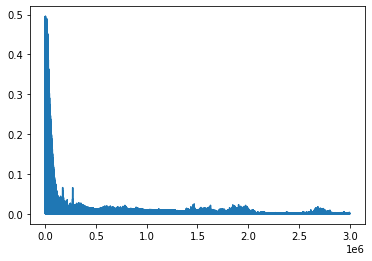

In [4]:
print(np.sum(loss_list))
plt.plot(loss_list)

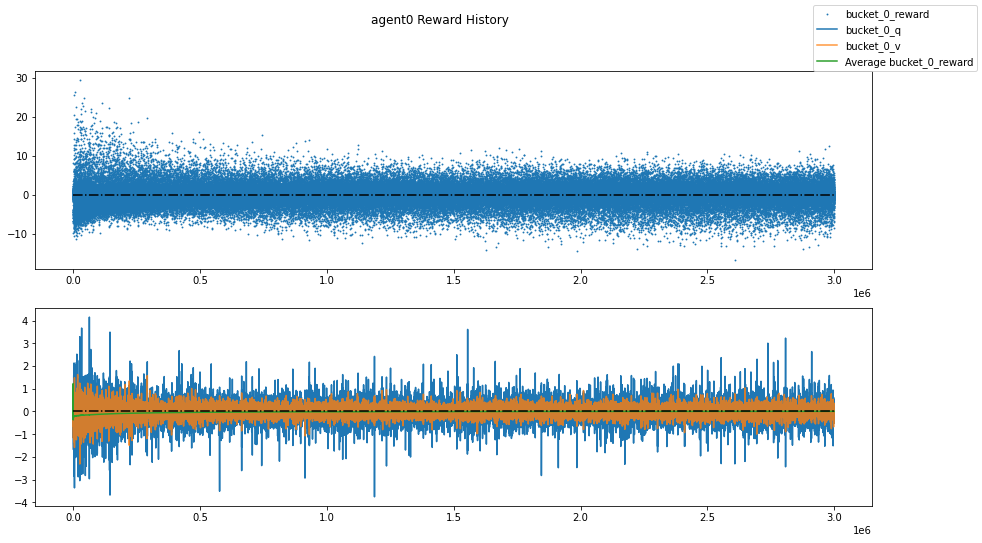

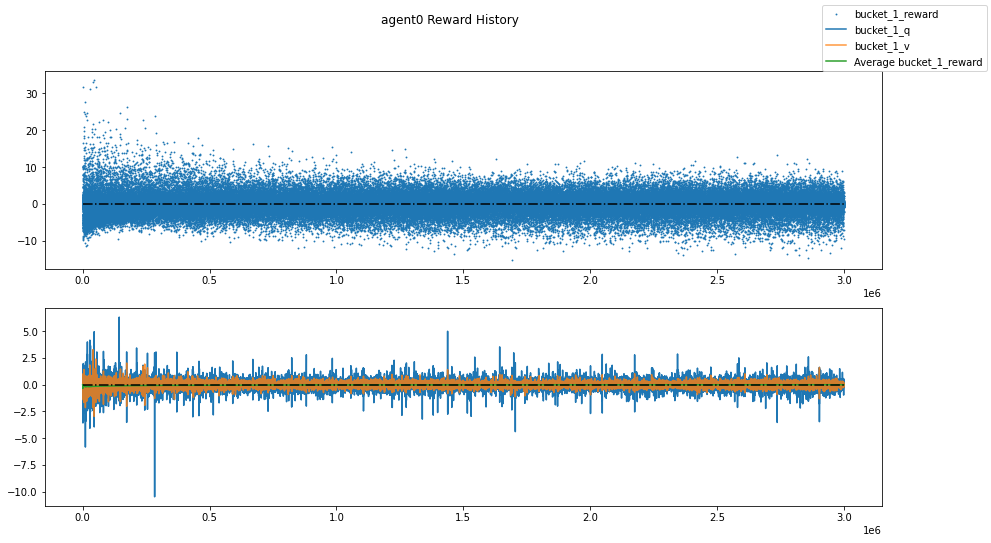

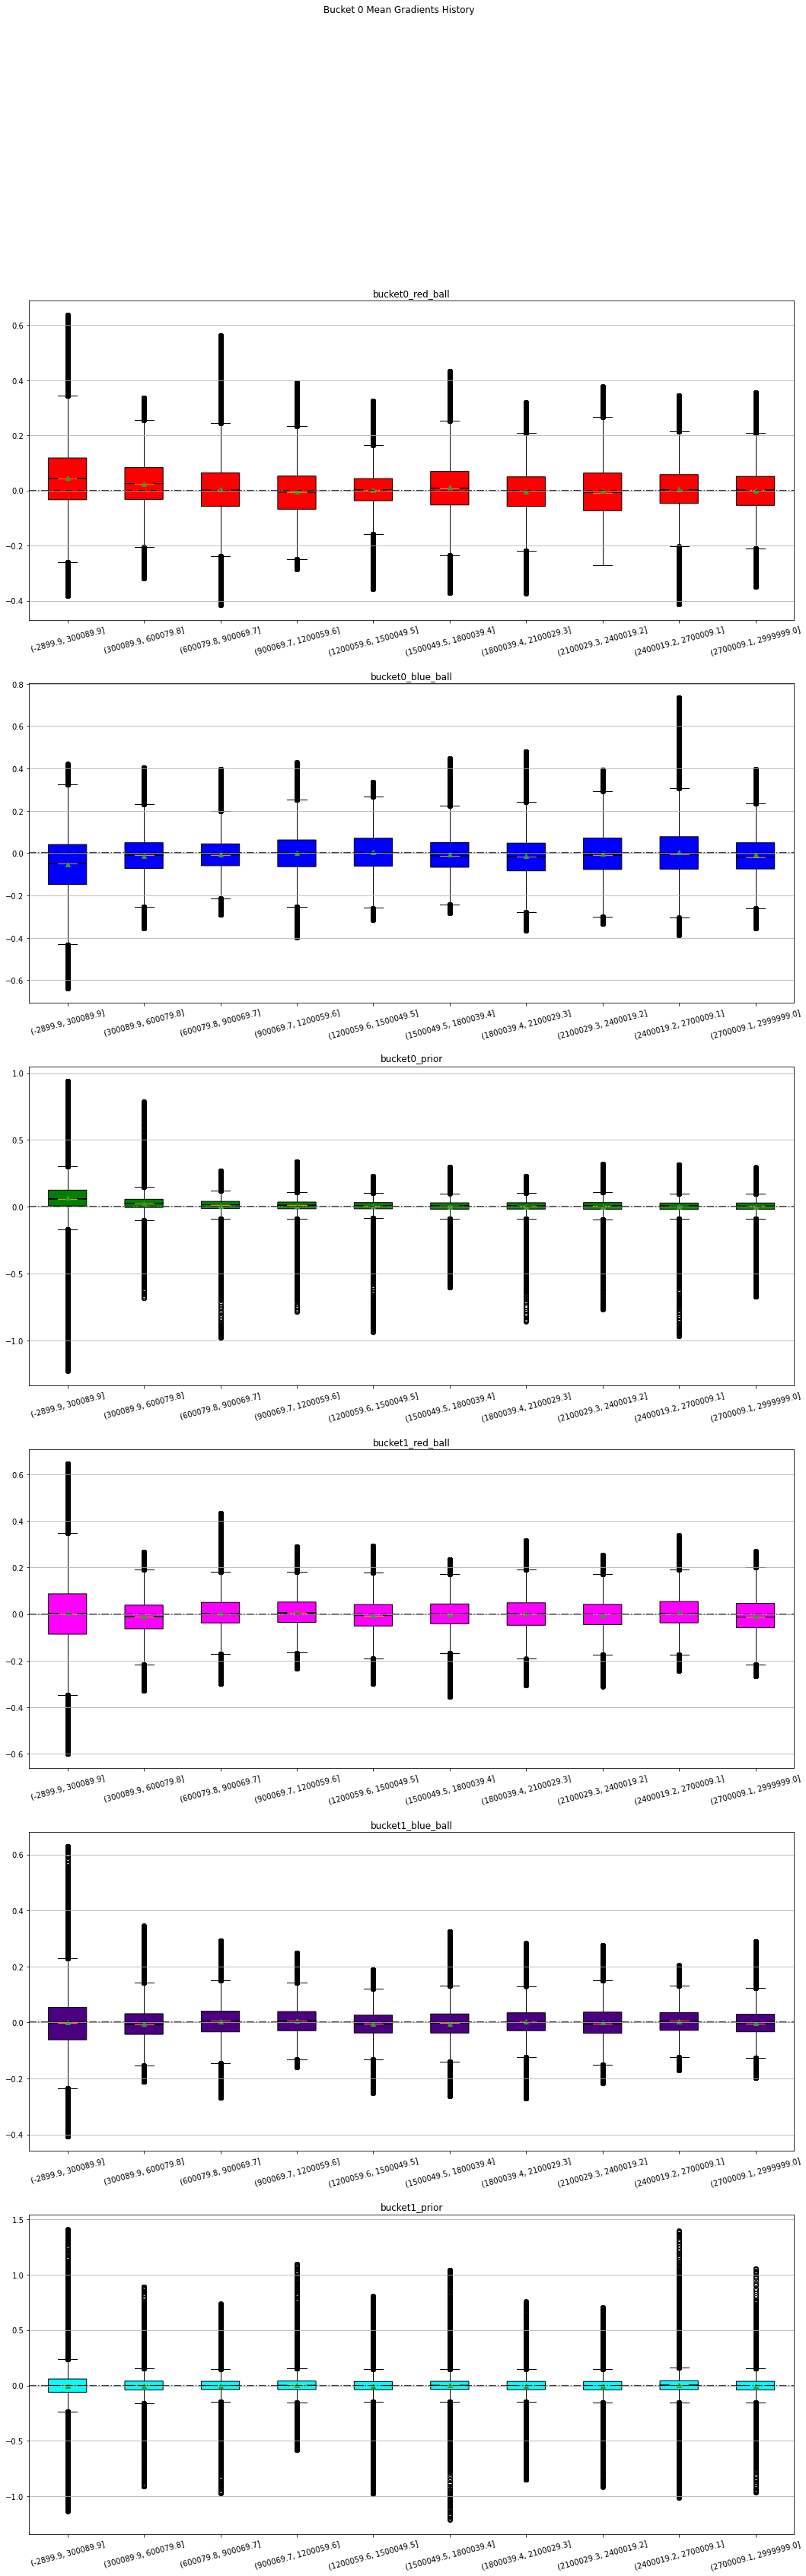

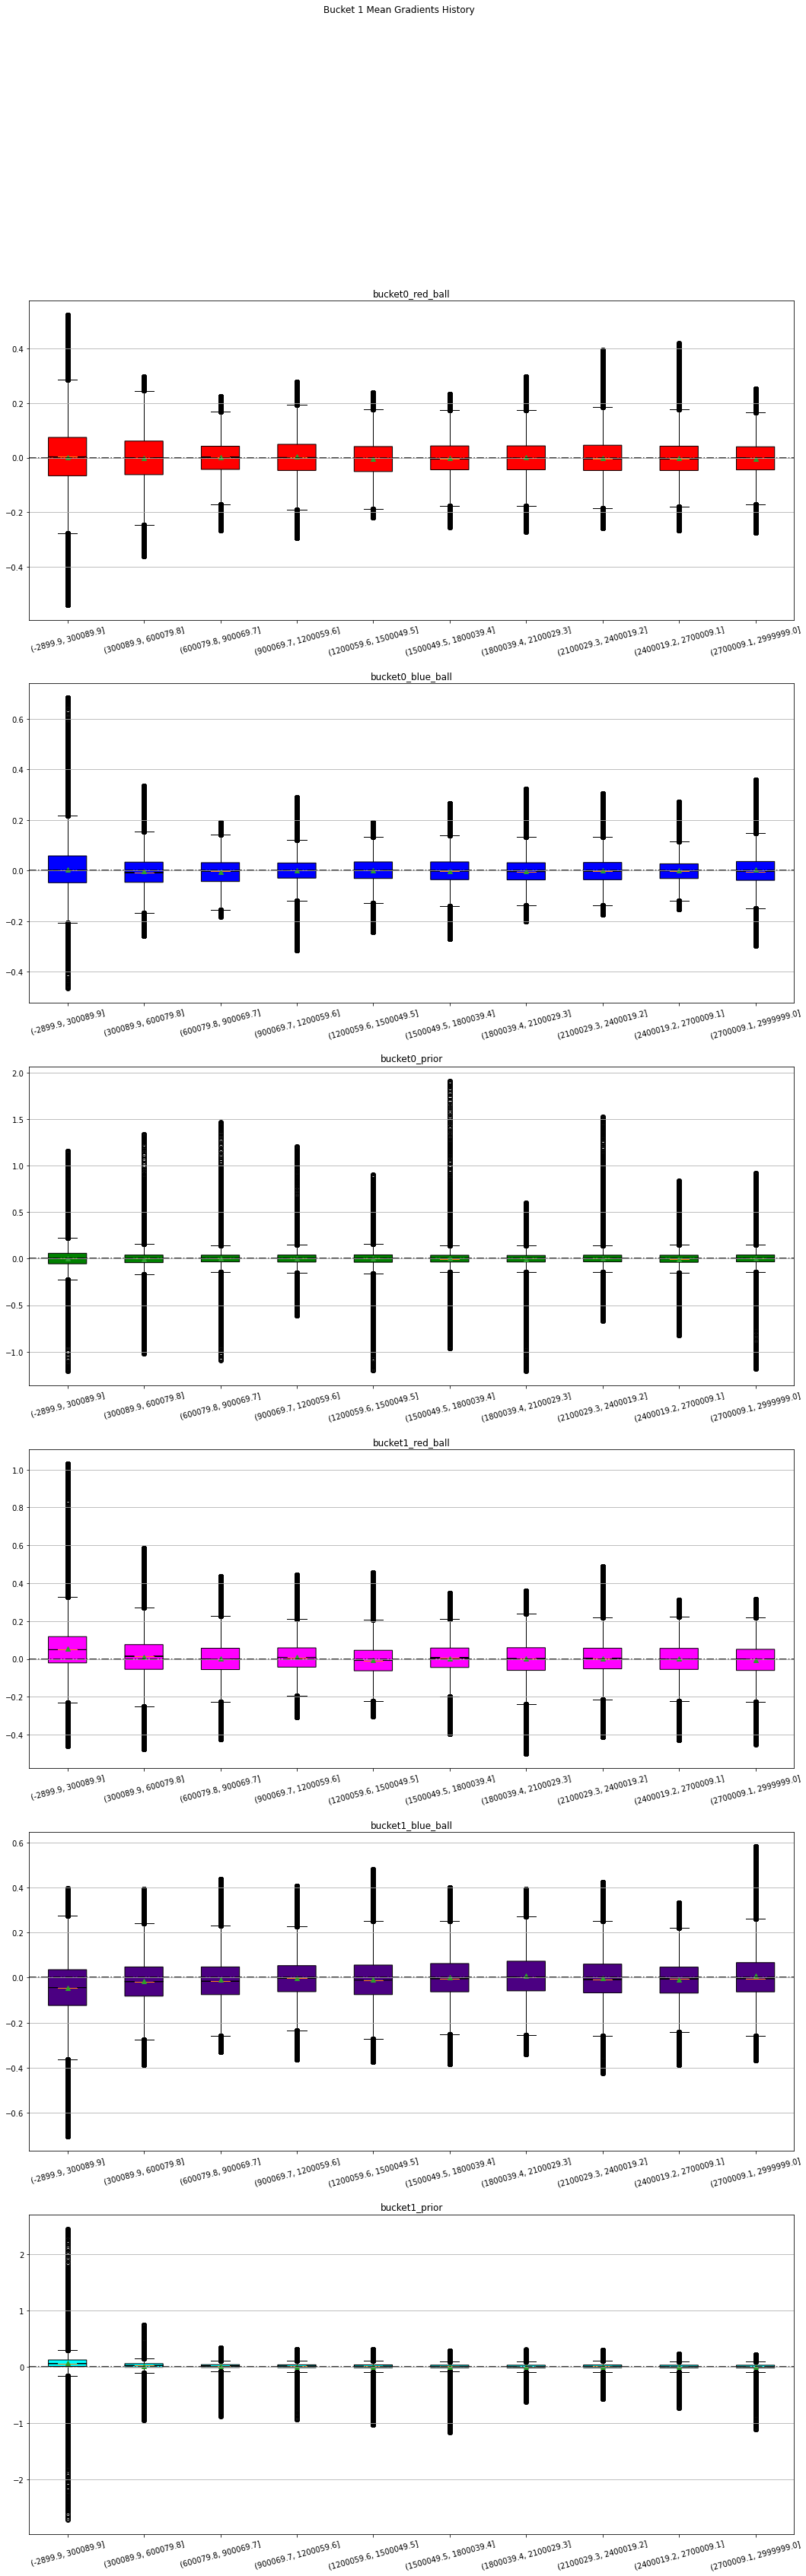

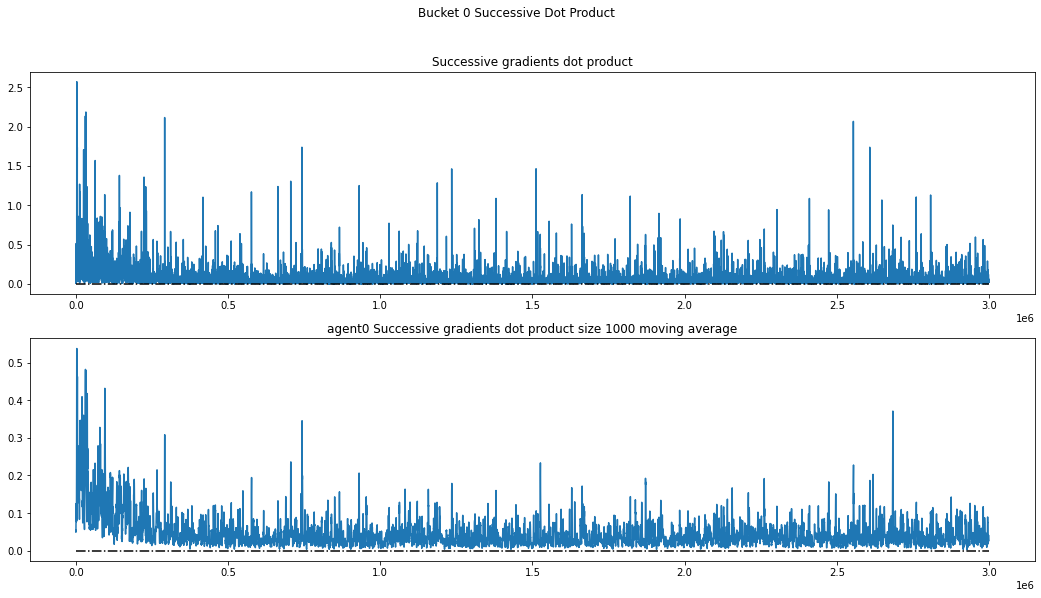

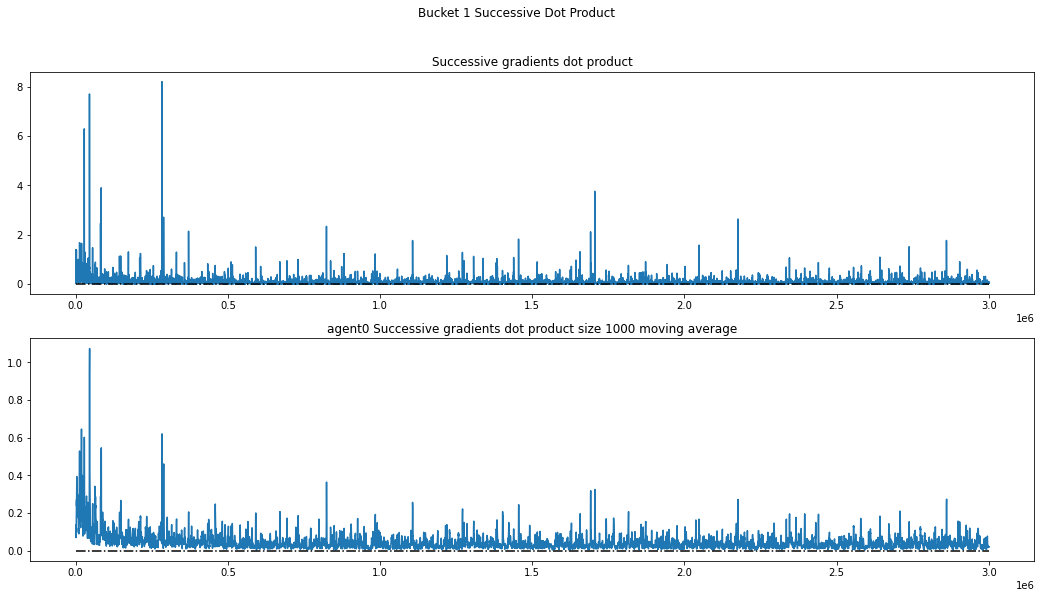

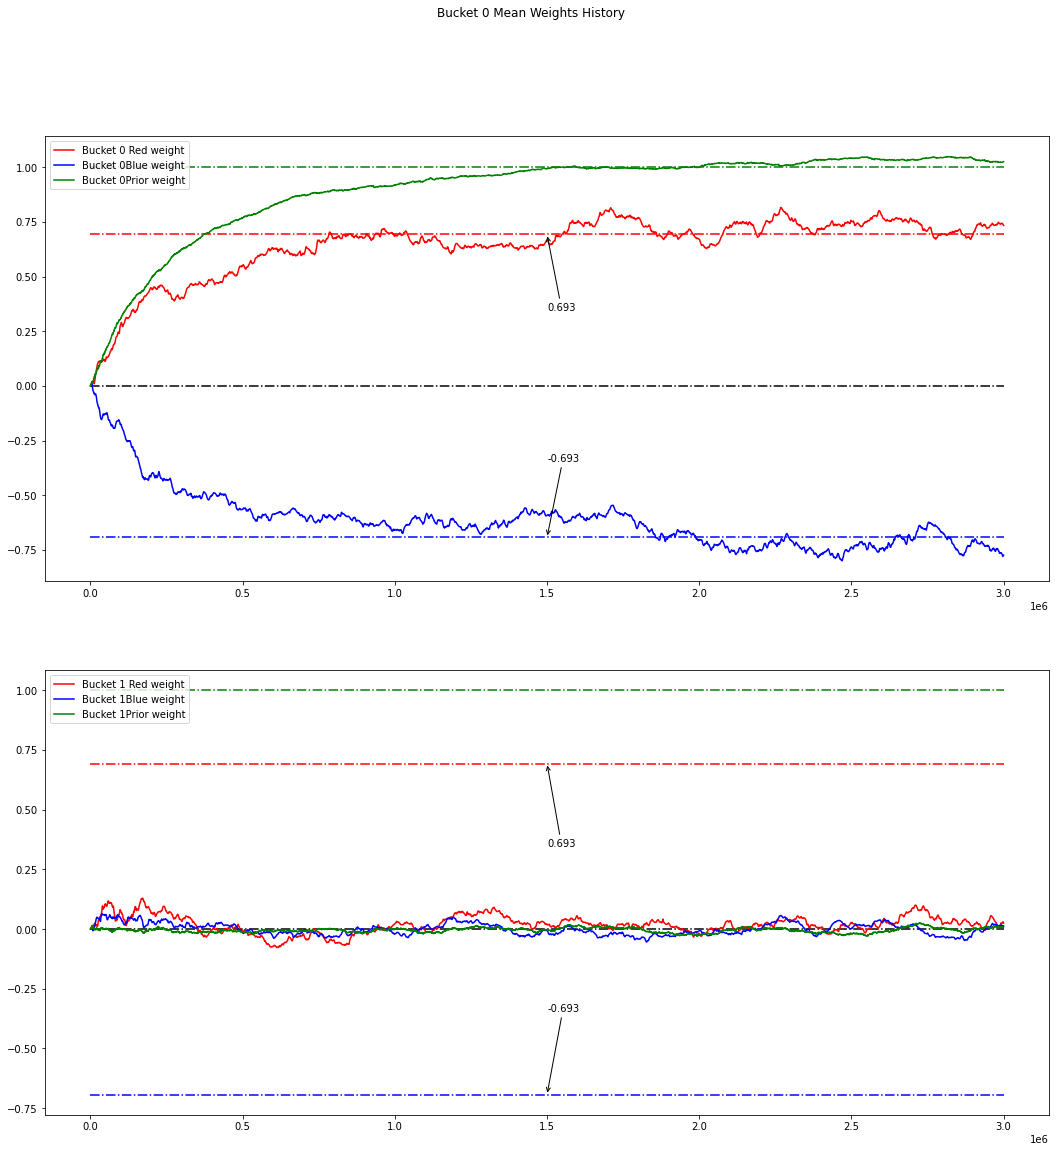

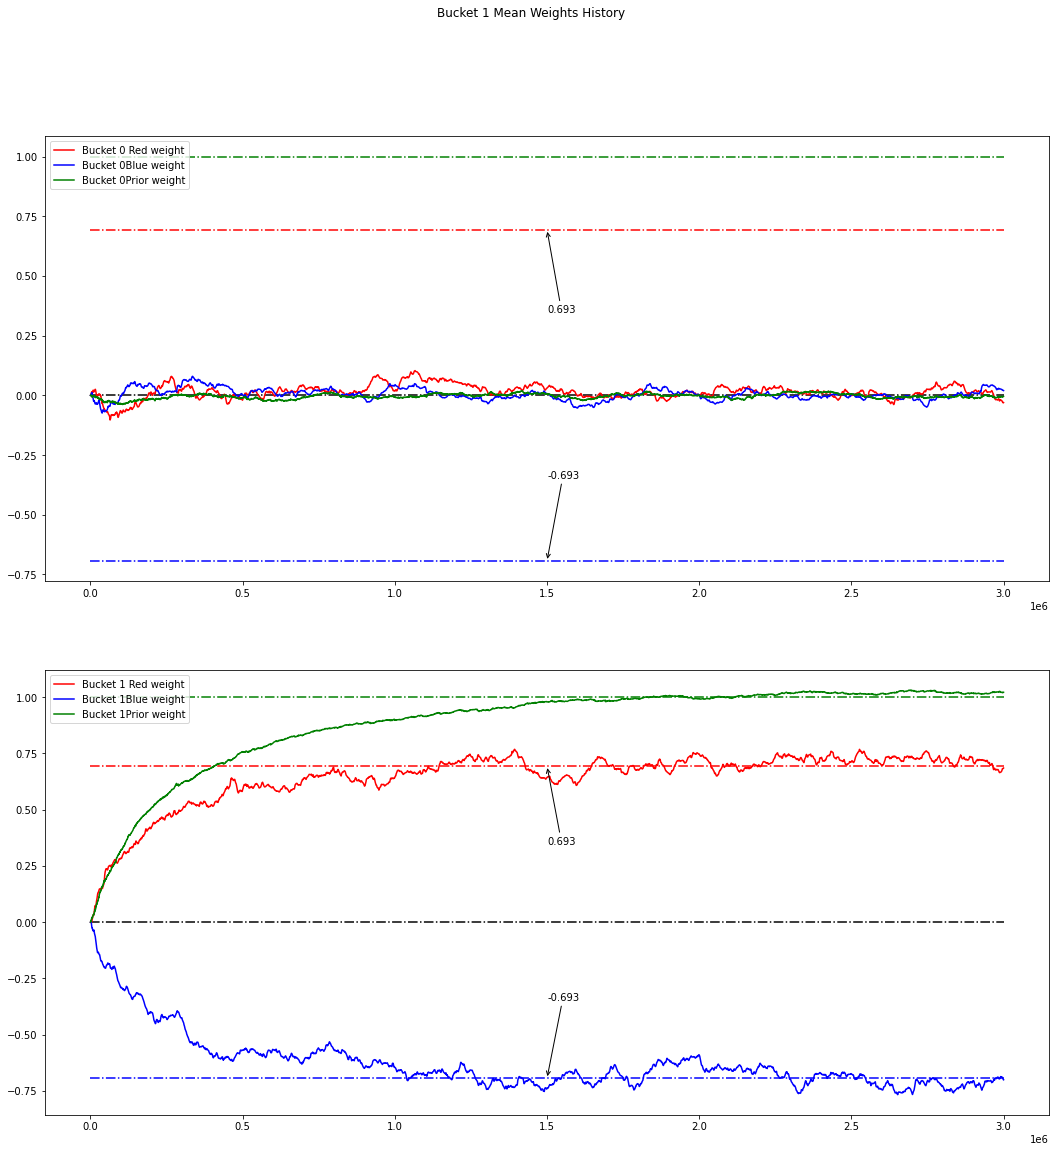

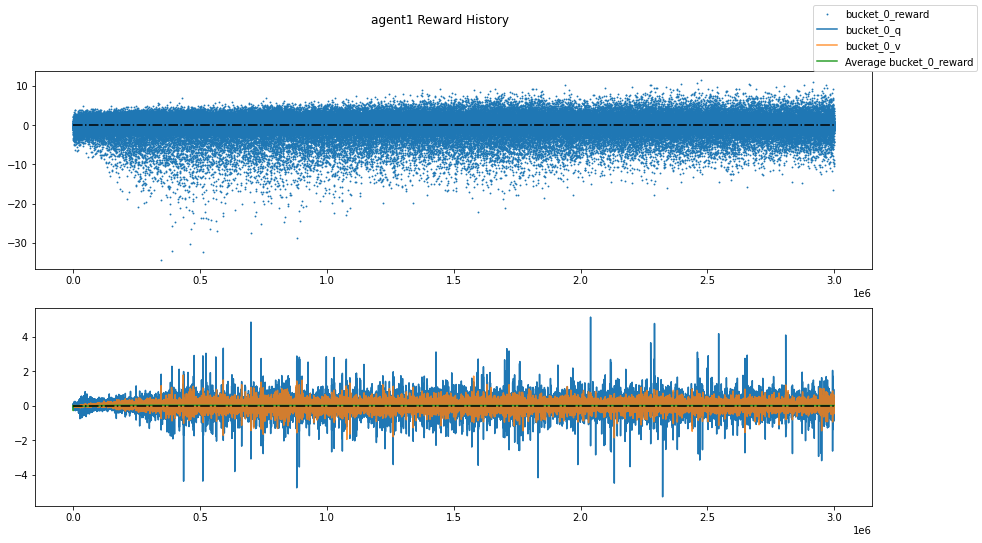

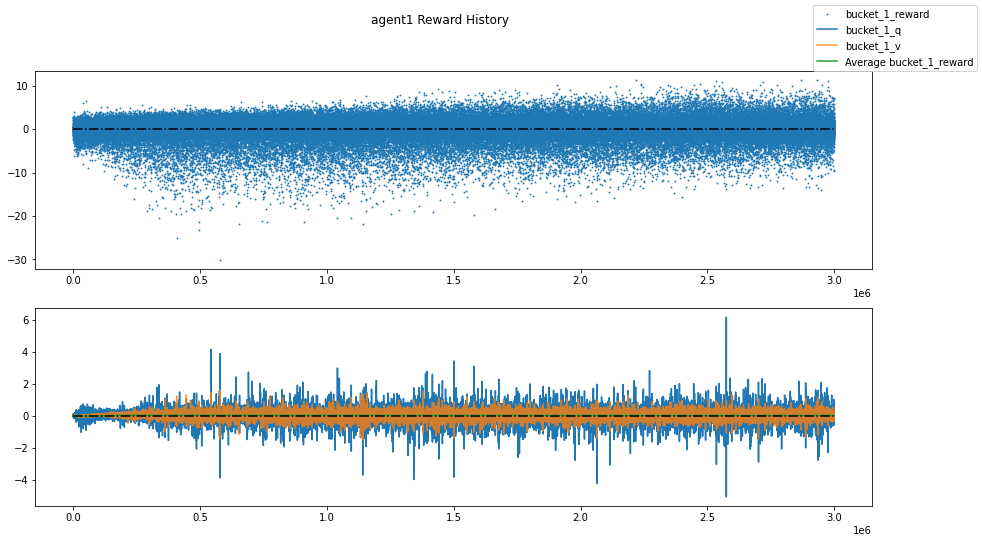

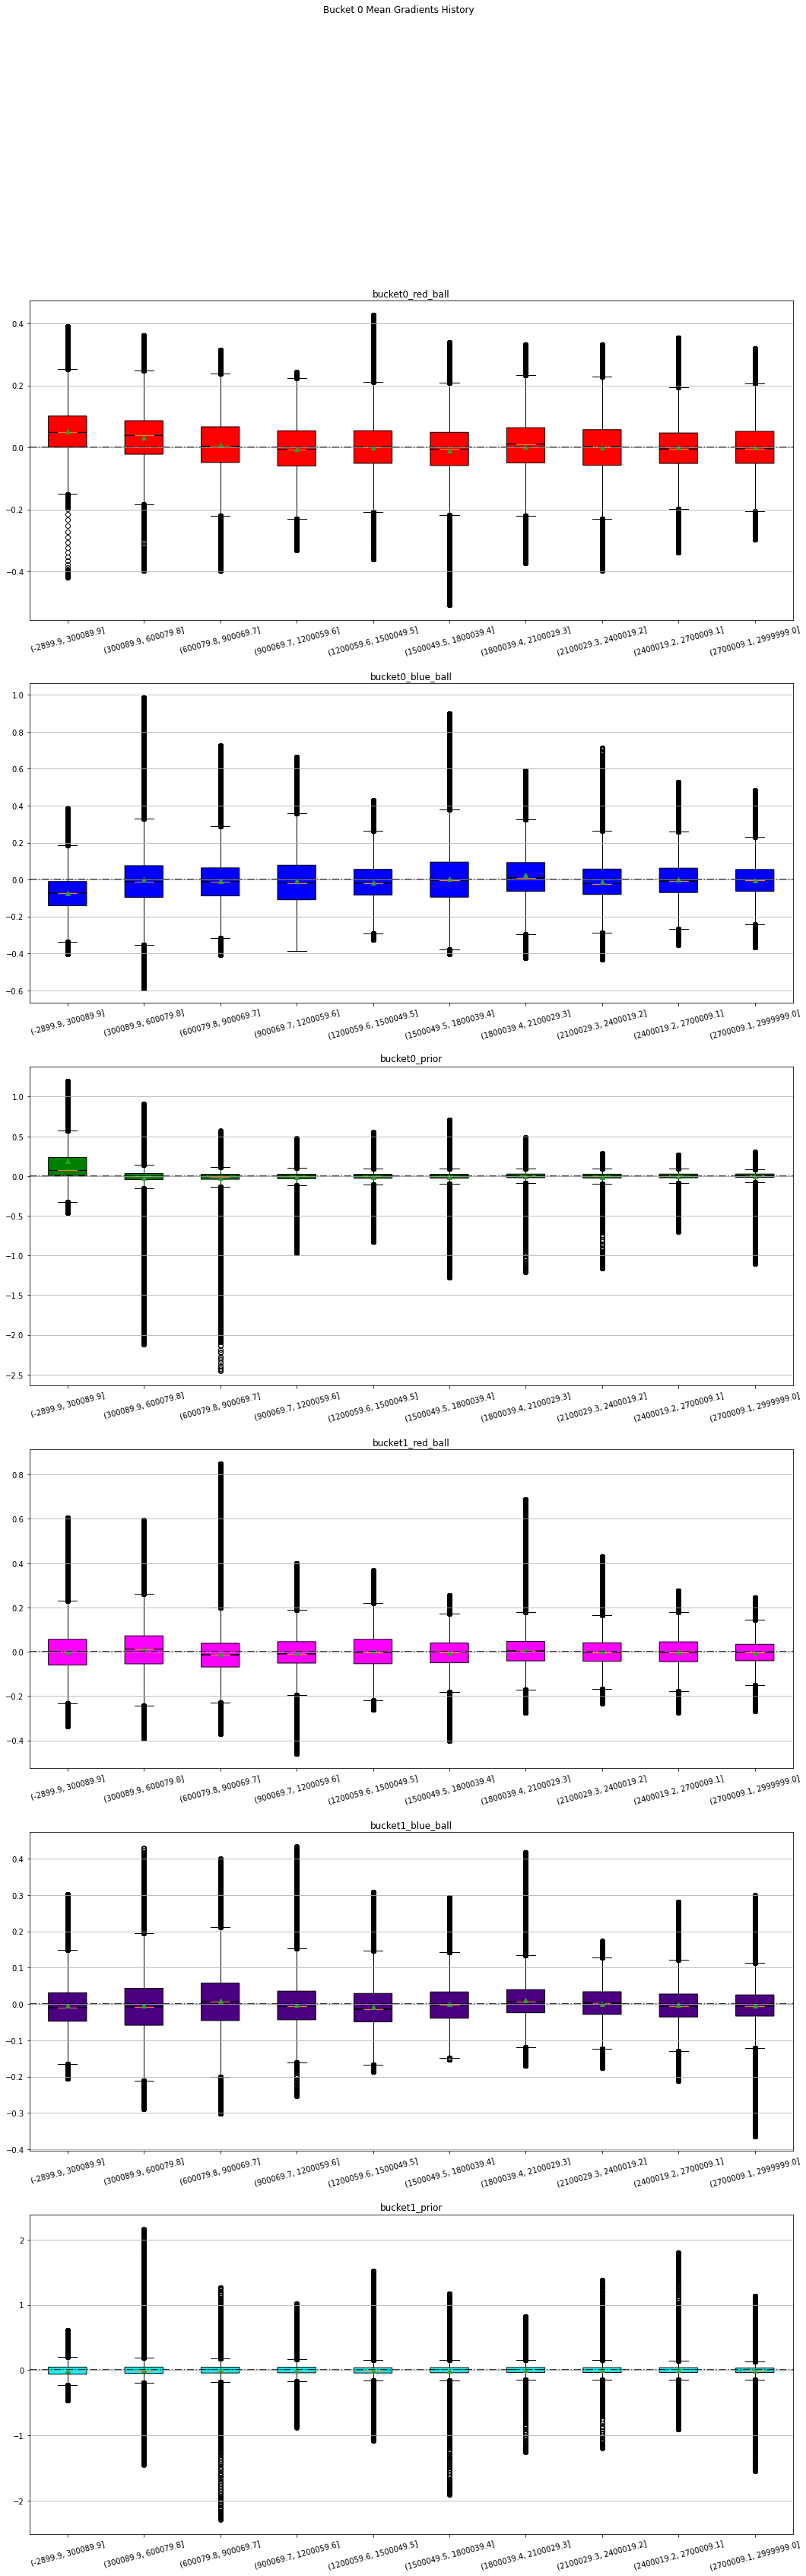

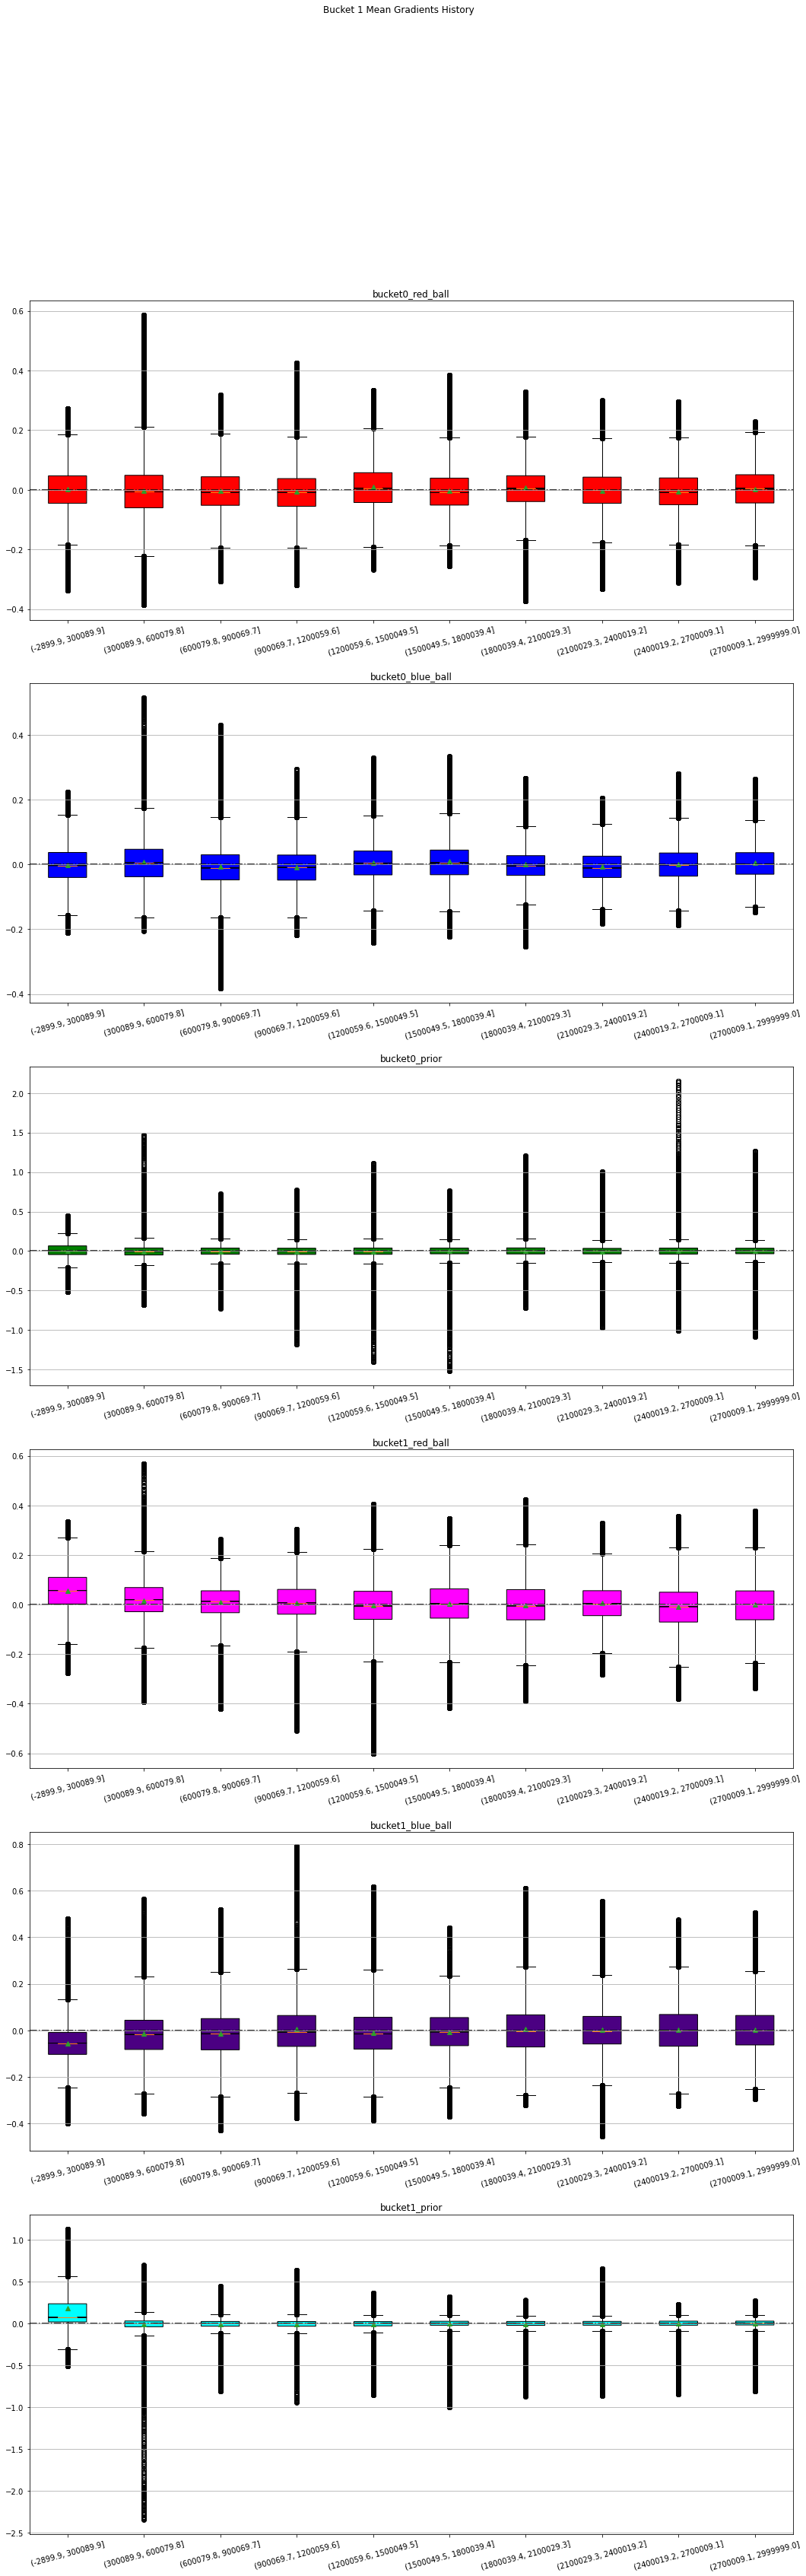

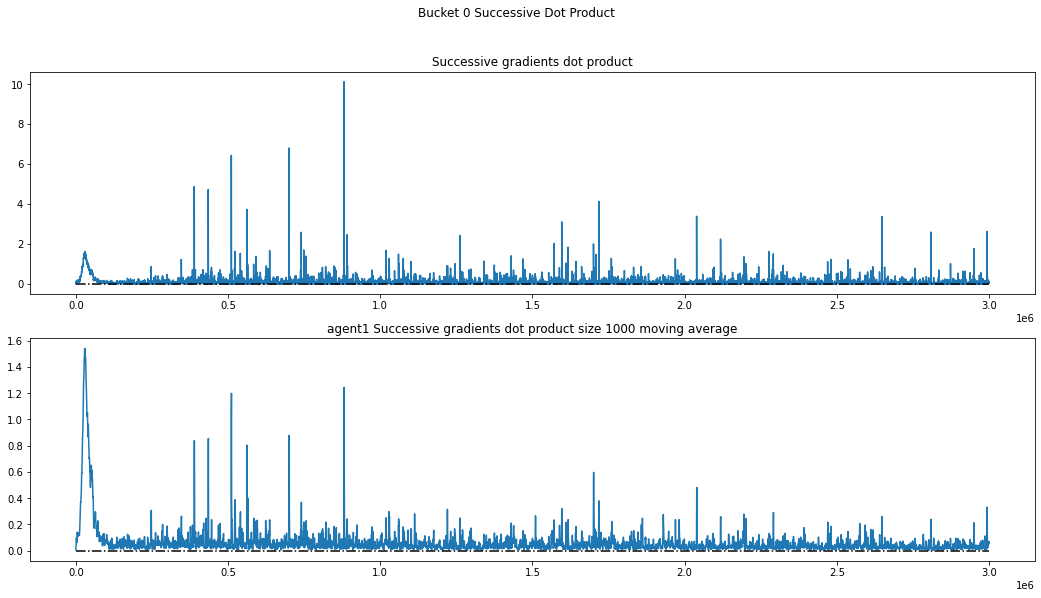

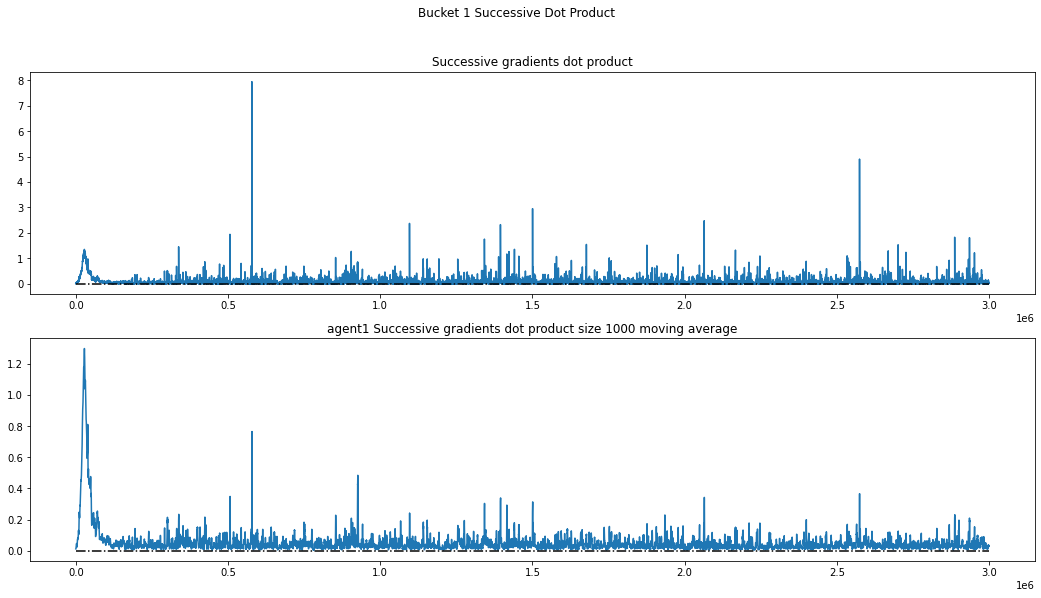

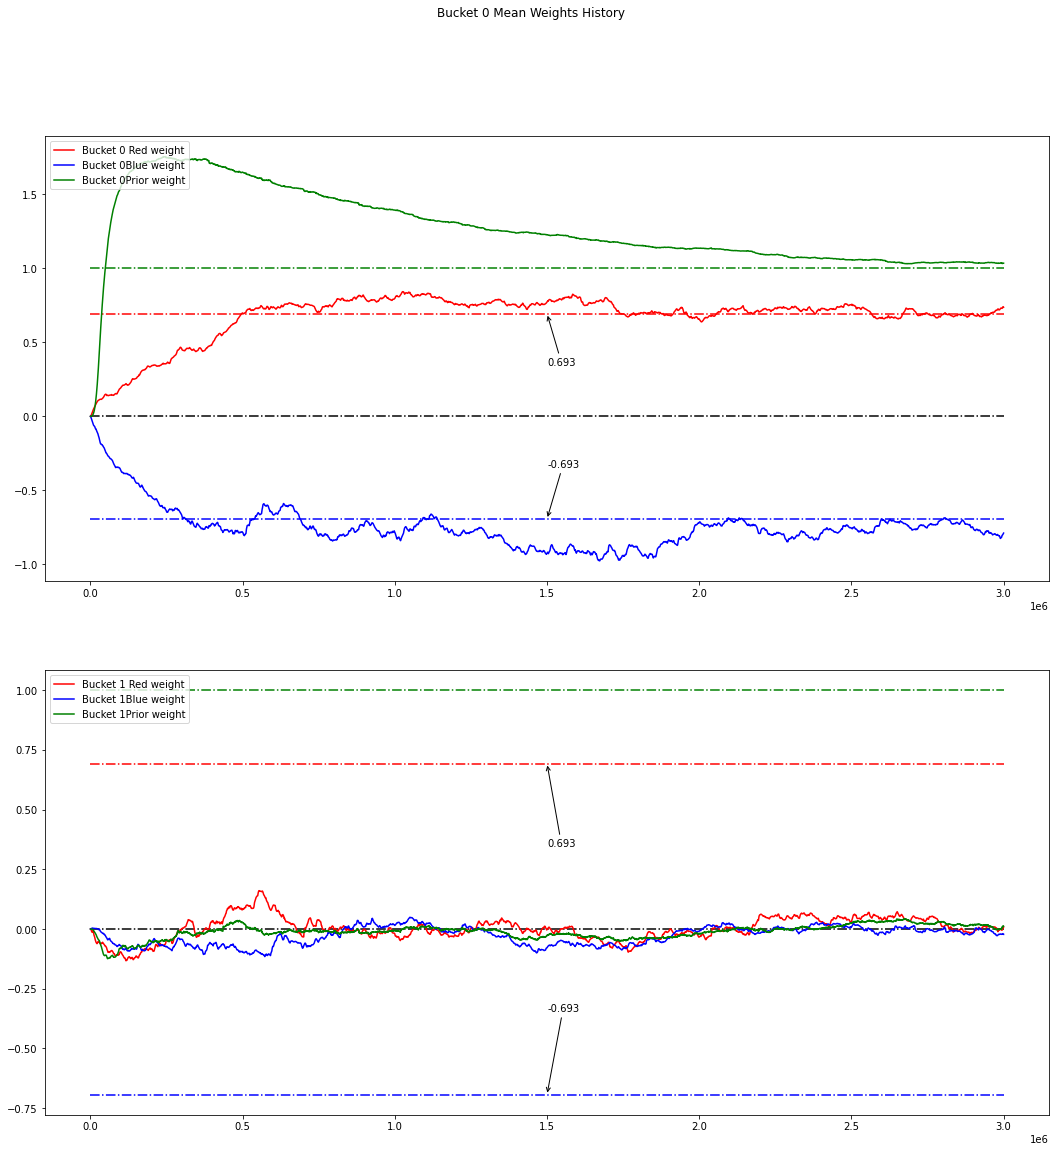

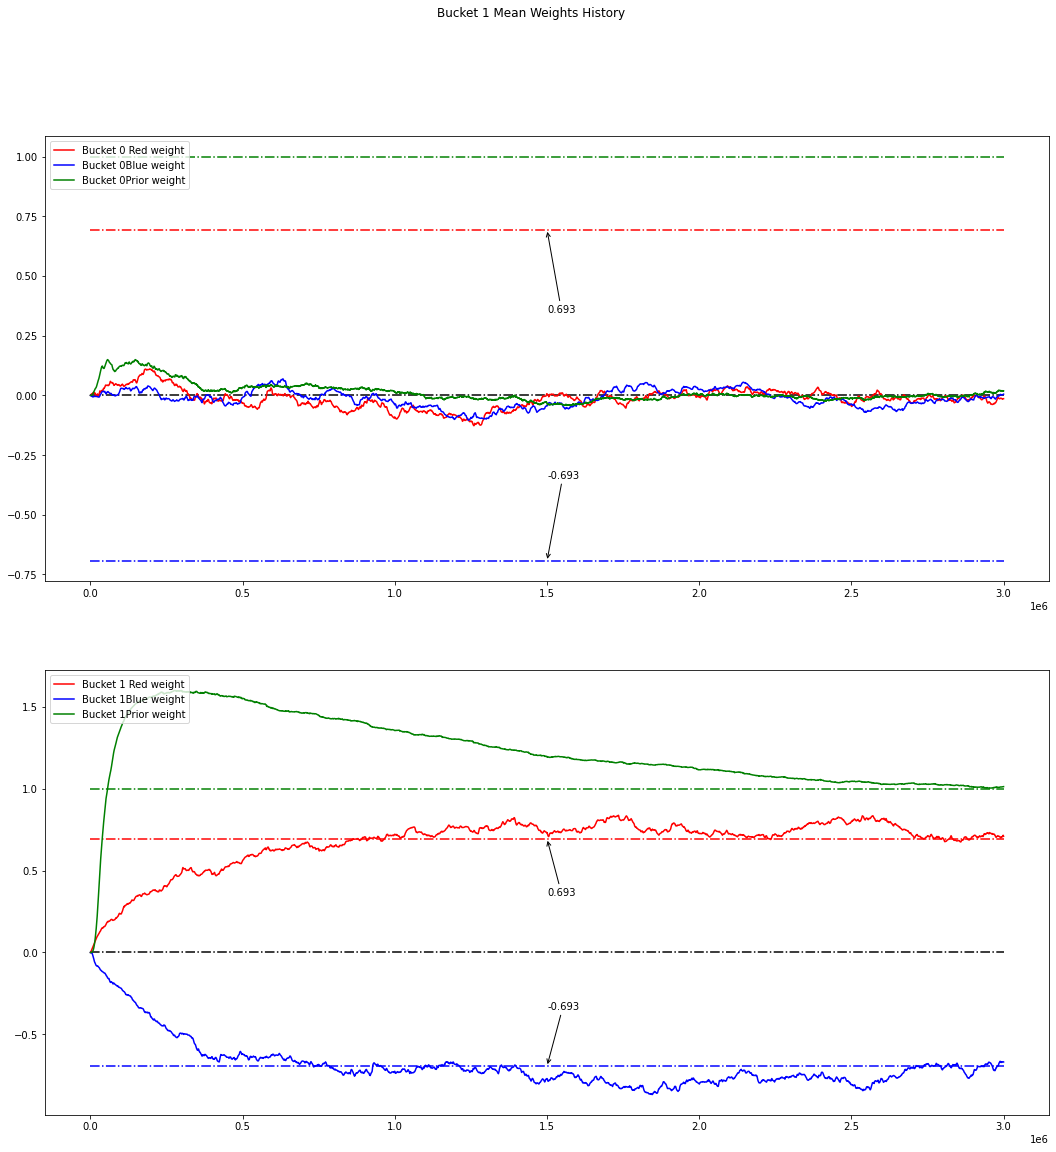

In [5]:
for agent in agent_list:
    agent.reward_history_plot()
    agent.mean_gradients_history_plot()
    agent.mean_gradients_successive_dot_product_plot()
#     agent.mean_history_plot()
    agent.mean_weights_history_plot()

In [ ]:
# agent_list[0].gradients_history_plot('q')
# agent_list[0].gradients_successive_dot_product_plot('q')
# #     agent.mean_history_plot()
# agent_list[0].weights_history_plot('q')

In [ ]:
agent_list[0].w_q

In [ ]:
agent_list[0].w_v

In [ ]:
from Environment import BucketColour, Ball
import numpy as np

In [ ]:
signal = agent_list[0].signal_encode(0, Ball.RED, 3/4)

In [ ]:
a = np.array([[0.1, 0.1]])
phi_array =  np.matmul(signal.T, a)

In [ ]:
phi_array

In [ ]:
v_array = np.matmul(signal, agent_list[0].w_v)

In [ ]:
v_array

In [ ]:
q_array = np.sum(phi_array * agent_list[0].w_q, axis=0, keepdims=True)
q_array